# Agreement study

In [1]:
import itertools
import matplotlib.pyplot as plt

from endoanalysis.agreement import OKSimilarity, compute_kappas, load_agreement_keypoints
from endoanalysis.datasets import PointsDataset
from endoanalysis.agreement import plot_agreement_matrices, compute_icc, plot_numbers, get_keypoints_nums
from endoanalysis.agreement import ptg_agreement, stud_agreement, ptg_stud_agreement

Our agreement study consists of 3 parts: preliminary, hidden and posterior studies. The files corresponding to each of them can be accesed with the help of the following yaml files:

In [2]:
YMLS = [
    "../data/master_ymls/preliminary_agreement.yaml",
    "../data/master_ymls/hidden_agreement.yaml",
    "../data/master_ymls/posterior_agreement.yaml"  
]
STUDIES = ["preliminary", "hidden", "posterior"]
EXPERTS =  ['ptg1', 'ptg2', 'ptg3', "stud1", "stud2", "stud3", "stud4"]

We also define a scale parameter for OK Similarity to perform a matching between the keypoints. We take this parameter s a mean radius of a nucleus:

In [3]:
SCALE = 7.63
similarity = OKSimilarity(scale=SCALE)

No we compute the kappas between each pair of experts. For each pair the following is done under the hood:

1) A similarity matrix between all the keypoints from expert_i and expet_j is composed
2) Linear sum assignemnt problem is solved to create a matching
3) With the help of the matching and the keypoints classes the Cohen kappa is calculated

Note, that there are two methods to deal with unmatched points: the first one is to skip them, and the second one is assign them a special class (background).

The first method will helps to estimate the agreement only on class labels but not on the keypoints numbers. The second method gives information about both kinds of errors, so it results in lesser kappa values.

Let's start with the first method:

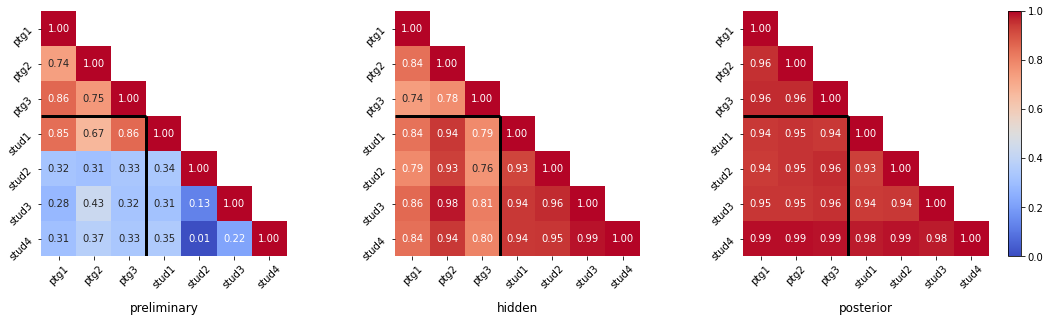

In [4]:
DROP_MISSED = True

experts_mapping = {expert: expert_i for expert_i, expert in enumerate(EXPERTS)}
kappas = {}

for study_name, yml_path in zip(STUDIES, YMLS):
    keypoints = load_agreement_keypoints(yml_path)
    kappas_study, experts_to_ids = compute_kappas(
        keypoints,
        similarity,
        EXPERTS,
        drop_missed=DROP_MISSED
    )
    kappas[study_name] = kappas_study

fig, ax = plot_agreement_matrices(kappas, STUDIES, EXPERTS)
# fig.savefig("figs/kappas_drop", dpi=300, bbox_inches='tight')
    

To get an estimate about overall annotation quality, we measire three quantities for each study: the mean betwwen the pathologists, the mean kappa between the students and the mean cappa in pathologist-student pairs:

In [5]:
for study_name in STUDIES:
    ptg_mean_kappa = ptg_agreement(kappas[study_name], EXPERTS, experts_mapping)
    stud_mean_kappa = stud_agreement(kappas[study_name], EXPERTS, experts_mapping)
    ptg_stud_mean_kappa = ptg_stud_agreement(kappas[study_name], EXPERTS, experts_mapping)
    print("%s study"%study_name)
    print("ptg: %.2f  stud: %.2f  ptg-stud: %.2f"%(ptg_mean_kappa, stud_mean_kappa, ptg_stud_mean_kappa))
    print()

preliminary study
ptg: 0.78  stud: 0.22  ptg-stud: 0.45

hidden study
ptg: 0.79  stud: 0.95  ptg-stud: 0.86

posterior study
ptg: 0.96  stud: 0.96  ptg-stud: 0.96



As we can see, the agreement in the hidden and posterior studies is quite good -- this is probably a result of the Q&A session which folowed the preliminary study


Now let's look at the kappas which take into account missed keypoints:

preliminary study
ptg: 0.63  stud: 0.15  ptg-stud: 0.27

hidden study
ptg: 0.62  stud: 0.47  ptg-stud: 0.53

posterior study
ptg: 0.77  stud: 0.50  ptg-stud: 0.64



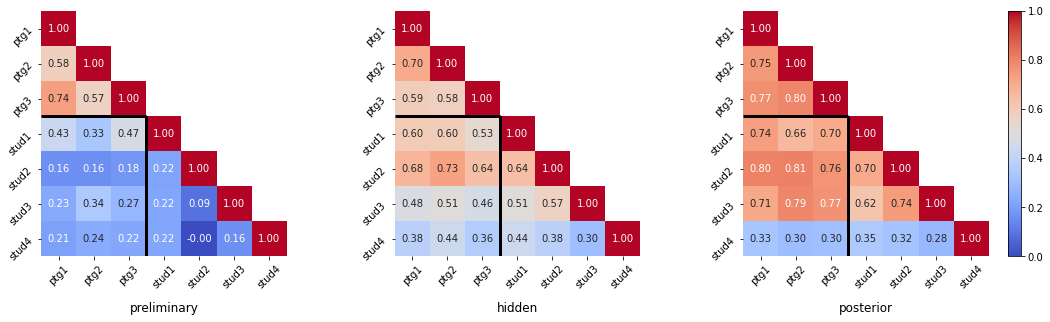

In [6]:
DROP_MISSED = False

experts_mapping = {expert: expert_i for expert_i, expert in enumerate(EXPERTS)}
kappas = {}

for study_name, yml_path in zip(STUDIES, YMLS):
    keypoints = load_agreement_keypoints(yml_path)
    kappas_study, experts_to_ids = compute_kappas(
        keypoints,
        similarity,
        EXPERTS,
        drop_missed=DROP_MISSED
    )
    kappas[study_name] = kappas_study

fig, ax = plot_agreement_matrices(kappas, STUDIES, EXPERTS)
# fig.savefig("figs/kappas_no_drop", dpi=300,bbox_inches='tight')
for study_name in STUDIES:
    ptg_mean_kappa = ptg_agreement(kappas[study_name], EXPERTS, experts_mapping)
    stud_mean_kappa = stud_agreement(kappas[study_name], EXPERTS, experts_mapping)
    ptg_stud_mean_kappa = ptg_stud_agreement(kappas[study_name], EXPERTS, experts_mapping)
    print("%s study"%study_name)
    print("ptg: %.2f  stud: %.2f  ptg-stud: %.2f"%(ptg_mean_kappa, stud_mean_kappa, ptg_stud_mean_kappa))
    print()

As we can see, the kappa values are notably less than in the previous observation. However, we not, that:

1) Kappa values between the pathologists are still big enough
2) The kappa values became higher after the priliminary study

Now let's look only on the keypoints numbers. To calculate the agreement, we use intraclass correlation coefficient #2:

In [7]:
EXPERTS = ["ptg1", "ptg2","ptg3", "stud1", "stud2", "stud3"] 
experts_mapping = {x: experts_mapping[x] for x in EXPERTS}

In [8]:
iccs = {}
keypoints_nums = {}
for study_name, yml_path in zip(STUDIES, YMLS):
    keypoints = load_agreement_keypoints(yml_path)
    keypoints_nums_study = get_keypoints_nums(keypoints, experts_mapping)
    keypoints_nums[study_name] = keypoints_nums_study

    iccs[study_name] = compute_icc(keypoints_nums_study, EXPERTS)
    print("%s study, ICC2: %.3f"%(study_name,iccs[study_name].iloc[1]["ICC"]))

preliminary study, ICC2: 0.839
hidden study, ICC2: 0.766
posterior study, ICC2: 0.948


And, finally, let's plot the keypoints numbers

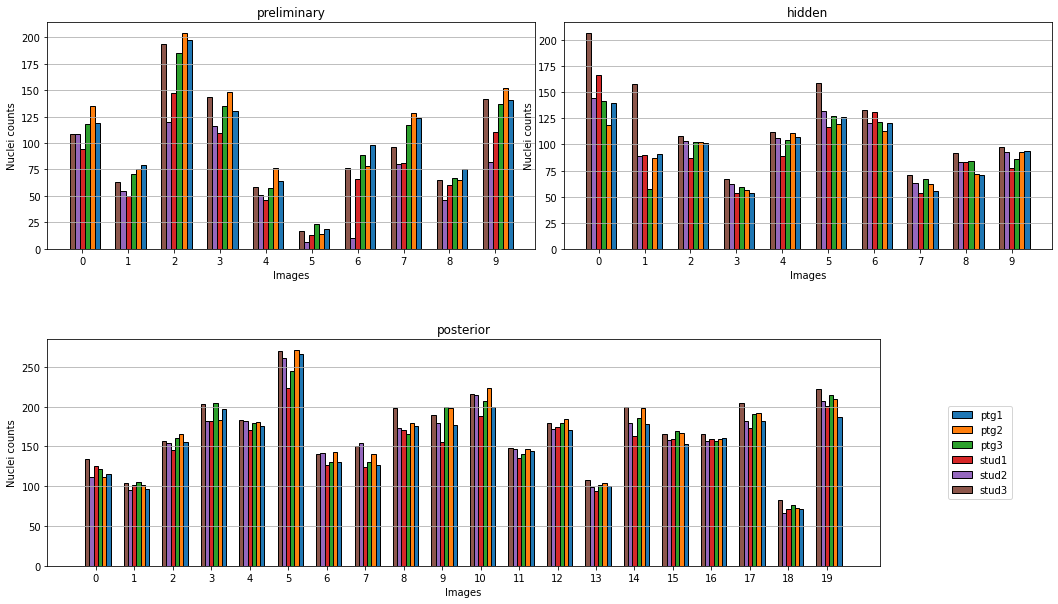

In [9]:
fig = plt.figure(figsize=(18,10))

gs = fig.add_gridspec(2,6)
ax1 = fig.add_subplot(gs[0, 0:3])
ax2 = fig.add_subplot(gs[0, 3:])
ax3 = fig.add_subplot(gs[1, :5])
ax4 = fig.add_subplot(gs[1, 5])
ax1.set_title("preliminary")
ax2.set_title("hidden")
ax3.set_title("posterior")

_  = plot_numbers(keypoints_nums["preliminary"], EXPERTS, experts_mapping, fig=fig, ax=ax1)
_  = plot_numbers(keypoints_nums["hidden"], EXPERTS,experts_mapping, fig=fig, ax=ax2)
_,_, handles  = plot_numbers(keypoints_nums["posterior"], EXPERTS, experts_mapping, fig=fig, ax=ax3)
ax4.legend(handles, EXPERTS, loc='center')
ax4.axis("off")
fig.subplots_adjust(hspace=0.4)
# fig.savefig("figs/nuclei_numbers_agreements", dpi=300, bbox_inches='tight')

As we can see, there is a rated which systematicly underannotates the nuclei -- probaly that's the reason why the agreement in the stuneds group is not big